# Lac Pavin geo env

In [1]:
import matplotlib, re, os, glob, datetime, difflib, random, time, math, json, wget
import matplotlib.pyplot as plt
import ecopy as ep
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess as sp
import geopandas, descartes, rtree
from skbio.stats.ordination import pcoa
from collections import defaultdict
sns.set('notebook')
%matplotlib inline 
# hide warnings
import warnings
warnings.filterwarnings('ignore')
# adjust cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from Bio import SeqIO, SeqUtils, SearchIO

In [2]:
rootdir = "/groups/banfield/projects/environmental/LacPavin/"

In [3]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

In [4]:
def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


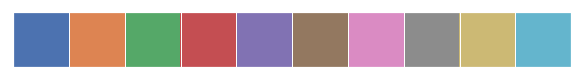

In [5]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
print(current_palette.as_hex())

# geo

In [6]:
geodir = rootdir + "/analysis/geo"
cmdir(geodir)

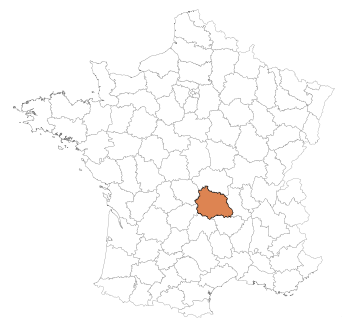

In [8]:
adm = pd.concat([geopandas.read_file(file) for file in glob.glob(geodir + "/*adm/*adm2.shp")])
# change projection
adm = adm.to_crs(epsg=3857)
sub = adm[adm["NAME_2"].str.contains("Puy")]
base = adm.plot(color='white', edgecolor='grey', linewidth=0.25, figsize=(6,8))
sub.plot(ax=base, color="#dd8452", edgecolor="black", linewidth=0.5,markersize=5)
plt.xlim([-6*1e5,9.5e5])
plt.ylim([5.2*1e6, 6.65*1e6])
plt.grid(False)
plt.axis('off')
plt.savefig(rootdir + "analysis/figures/france.svg", format="svg")
plt.show()

In [9]:
# get region
bounding_box = sub.envelope
subdf = geopandas.GeoDataFrame(geopandas.GeoSeries(bounding_box), columns=['geometry'])
region = geopandas.overlay(subdf, adm, how='intersection')

In [10]:
# get cities
cities = pd.concat([geopandas.read_file(file) for file in glob.glob(geodir + "/*adm/*adm3.shp")])
cities = cities.to_crs(epsg=3857)
csub = cities[cities["NAME_3"].str.contains("Clermont-Ferrand")]

In [11]:
# define pavin
df = pd.DataFrame({'poi': ['Lac Pavin'],
                   'Latitude': [45.4990],
                   'Longitude': [2.8869]})
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))
gdf.crs = {'init' :'epsg:4326'}  
gdf = gdf.to_crs(epsg=3857)

In [12]:
matplotlib.rc('axes',edgecolor='orange')

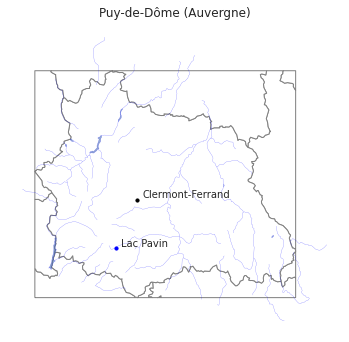

In [14]:
water = pd.concat([geopandas.read_file(file) for file in glob.glob(geodir + "/*wat/*shp")])
# change projection
water = water.to_crs(epsg=3857)
wsub = geopandas.sjoin(water, sub, op='intersects')
a = region.plot(color='white', edgecolor='grey',figsize=(6,8))
wsub.plot(ax=a,edgecolor='blue', linewidth=0.25, alpha=0.6)
csub.centroid.plot(ax=a,color='black',markersize=10)
# clermont
coords = list(csub.iloc[0].geometry.centroid.coords[0])
labelpos = [coords[0]*1.01,coords[1]]
plt.annotate(s=csub.iloc[0]["NAME_3"], xy=labelpos, va="bottom")
# pavin
coords = list(gdf.iloc[0].geometry.centroid.coords[0])
gdf.geometry.plot(ax=a,color='blue', markersize=10)
labelpos = [coords[0]*1.01,coords[1]]
plt.annotate(s=gdf.iloc[0]["poi"], xy=labelpos, va="bottom")
plt.grid(False)
plt.axis('off')
plt.title("%s (%s)" %(sub["NAME_2"].iloc[0], sub["NAME_1"].iloc[0]))
plt.savefig(rootdir + "analysis/figures/auvergne.svg", format="svg")
plt.show()

# environmental

In [6]:
envdir = rootdir + "/analysis/env/"
cmdir(envdir)

### environmental data

In [7]:
# read in + process
oprofiles = []

for table in glob.glob("/groups/banfield/projects/environmental/LacPavin/env_data/envdata*"):
    
    try:
        df = pd.read_csv(table, sep="\t")[["depth", "O2_mg/L", "O2_%"]]
    except: df = pd.read_csv(table, sep=",")[["depth", "O2_mg/L", "O2_%"]]
    
    df["year"] = os.path.basename(table).split(".csv")[0].split("_")[1]
    df["depth_meters"] = df["depth"].apply(lambda x: x*-1)
    oprofiles.append(df)

profiledf = pd.concat(oprofiles)
profiledf.head()

,depth,O2_mg/L,O2_%,year,depth_meters
0,0.27,9.54,104.22,2018,-0.27
1,0.27,9.54,104.25,2018,-0.27
2,0.27,9.54,104.21,2018,-0.27
3,0.28,9.54,104.17,2018,-0.28
4,0.30,9.54,104.21,2018,-0.30


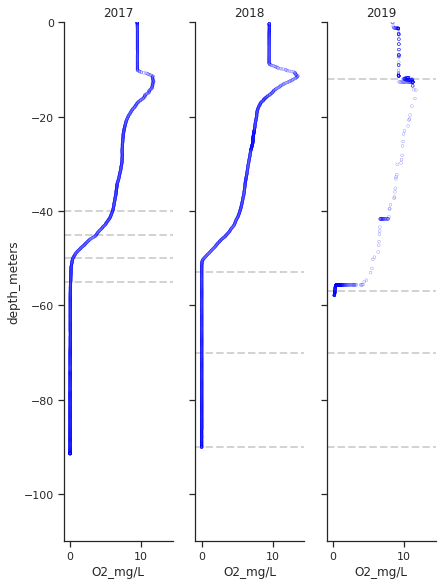

In [18]:
# plot
sns.set_style("ticks")
g = sns.relplot(x="O2_mg/L", y="depth_meters",
                col="year", col_order=["2017", "2018", "2019"],
                data=profiledf, color="white",
                height=8, alpha=0.8, aspect=0.25,
                kind="scatter", **{"edgecolor":"blue", "s":8})
g.set_titles("{col_name}").set(ylim=(-110,0))

for i,ax in enumerate(g.axes.flat):
    
    if i==0:
        samples = [40,45,50,55]
    elif i==1:
        samples = [53, 70, 90]
    else: samples = [12, 57, 70, 90]
        
    for sample in samples:
        ax.axhline(-1*sample, ls="--", zorder=0, linewidth=2,color="lightgrey")

plt.savefig(rootdir + "analysis/figures/oxygen.svg", format="svg")
plt.show()